# Similarity Search for Recommendations

In [5]:
import tensorflow as tf

# Check TensorFlow version
print('TensorFlow version:', tf.__version__)

# List physical devices
print('Available GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Enable memory growth for the GPU

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPU memory growth enabled')
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


In [7]:
# Import necessary libraries # type: ignore
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.neighbors import NearestNeighbors


from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity


# Part 1: Embedding Extraction

In [8]:
database_embeddings = np.load('../../data/embeddings/embeddings.npy')
database_labels = np.load('../../data/embeddings/labels.npy')
paths = np.load('../../data/embeddings/paths.npy')
ids = [path[-13: -4] for path in paths]

# Create a DataFrame
data = pd.DataFrame({
    'id': ids,
    'embedding': list(database_embeddings),  # Convert arrays to list for DataFrame compatibility
    'label': list(database_labels),
    'path': list(paths)
})

# Display the DataFrame
print(data.head())

          id                                          embedding label  \
0  772176001  [0.99997866, 5.095979e-06, 3.766936e-06, 4.415...     0   
1  482199001  [0.9999788, 6.3437246e-06, 3.1271677e-06, 4.07...     0   
2  799365027  [0.99992037, 2.17127e-05, 1.5078049e-05, 1.498...     0   
3  834229001  [0.99994063, 1.4772901e-05, 8.577511e-06, 1.07...     0   
4  469562065  [1.0, 9.569805e-09, 7.331157e-09, 1.03000115e-...     0   

                                     path  
0  ../data/dataset/train/0/0772176001.jpg  
1  ../data/dataset/train/0/0482199001.jpg  
2  ../data/dataset/train/0/0799365027.jpg  
3  ../data/dataset/train/0/0834229001.jpg  
4  ../data/dataset/train/0/0469562065.jpg  


In [9]:
print(f'embeddings shape: {database_embeddings.shape}')
print(f'labels shape: {database_labels.shape=}')

embeddings shape: (6000, 6)
labels shape: database_labels.shape=(6000,)


In [10]:
def extract_embeddings(img_path):
    image = Image.open(img_path).convert('RGB')
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    preprocessed_image = np.expand_dims(image_array, axis=0)  # Add batch

    m = load_model('../../models/resnest50.keras')
    query_image_embeddings = m.predict(preprocessed_image)
    query_image_class = np.argmax(query_image_embeddings, axis=1)[0]
    return (query_image_embeddings, query_image_class)

In [27]:
query_image_path = '../../image.jpg'
query_image_embeddings, query_image_class = extract_embeddings(query_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [28]:
print(f'{query_image_class=}')
print(f'{query_image_embeddings.shape=}')
print(f'{query_image_embeddings=}')

query_image_class=1
query_image_embeddings.shape=(1, 6)
query_image_embeddings=array([[0.16140562, 0.2617351 , 0.11266264, 0.1793229 , 0.17081559,
        0.11405814]], dtype=float32)


# Part 2: Real-Time Similarity Search

In [29]:
def compute_similarities(query_image, database_embeddings, database_labels, k = 5):
    
    # Compute similarities
    similarities = cosine_similarity(query_image, database_embeddings)
    top_indices = similarities[0].argsort()[-k:][::-1]  # Get top-k indices
    print(f'{top_indices=}')
    
    return top_indices, database_labels[top_indices]

# Example recommendation for a query image
indices, labels = compute_similarities(query_image_embeddings, database_embeddings, database_labels)
print(f'Recommended labels: {labels}')


top_indices=array([4584, 2609, 5301, 3021, 5814])
Recommended labels: ['4' '3' '1' '2' '2']


# Part 3: Recommendation System KNN

## 3.1. Train the KNN Model

In [30]:
data

,id,embedding,label,path
0,772176001,"[0.99997866, 5.095979e-06, 3.766936e-06, 4.415...",0,../data/dataset/train/0/0772176001.jpg
1,482199001,"[0.9999788, 6.3437246e-06, 3.1271677e-06, 4.07...",0,../data/dataset/train/0/0482199001.jpg
2,799365027,"[0.99992037, 2.17127e-05, 1.5078049e-05, 1.498...",0,../data/dataset/train/0/0799365027.jpg
3,834229001,"[0.99994063, 1.4772901e-05, 8.577511e-06, 1.07...",0,../data/dataset/train/0/0834229001.jpg
4,469562065,"[1.0, 9.569805e-09, 7.331157e-09, 1.03000115e-...",0,../data/dataset/train/0/0469562065.jpg
...,...,...,...,...
5995,789309002,"[0.41518137, 0.0710737, 0.02995428, 0.02838708...",5,../data/dataset/test/5/0789309002.jpg
5996,785827001,"[0.08966651, 0.26123443, 0.07506106, 0.0822247...",5,../data/dataset/test/5/0785827001.jpg
5997,780729002,"[0.53429574, 0.048234142, 0.028256482, 0.02658...",5,../data/dataset/test/5/0780729002.jpg
5998,789309003,"[0.9402716, 0.016005095, 0.0052318648, 0.00525...",5,../data/dataset/test/5/0789309003.jpg


In [31]:
# Logic for recommendations based on the class
def get_valid_items(input_class):
    valid_combinations = {
        '0': ['2', '3', '4', '5'],
        '1': ['2'],
        '2': ['0', '1', '5'],
        '3': ['0'],
        '4': ['0'],
        '5': ['0', '2'],
    }
    valid_classes = valid_combinations.get(input_class, [])

    valid_items = data[data['label'].isin(valid_classes)]

    valid_items_embeddings = np.stack(valid_items['embedding'])
    valid_items_labels = np.stack(valid_items['label'])
    valid_items_paths = np.stack(valid_items['path'])
    
    return valid_items_embeddings, valid_items_labels, valid_items_paths

In [32]:
valid_items_embeddings, valid_items_labels, valid_items_paths = get_valid_items(str(query_image_class))
len(valid_items_paths)

1000

In [33]:
valid_items_paths

array(['../data/dataset/train/2/0792521002.jpg',
       '../data/dataset/train/2/0796035005.jpg',
       '../data/dataset/train/2/0771730005.jpg',
       '../data/dataset/train/2/0794620002.jpg',
       '../data/dataset/train/2/0779691002.jpg',
       '../data/dataset/train/2/0776771001.jpg',
       '../data/dataset/train/2/0838823003.jpg',
       '../data/dataset/train/2/0796522003.jpg',
       '../data/dataset/train/2/0776299004.jpg',
       '../data/dataset/train/2/0411013010.jpg',
       '../data/dataset/train/2/0799190002.jpg',
       '../data/dataset/train/2/0844931004.jpg',
       '../data/dataset/train/2/0797394002.jpg',
       '../data/dataset/train/2/0771519003.jpg',
       '../data/dataset/train/2/0777694005.jpg',
       '../data/dataset/train/2/0845497003.jpg',
       '../data/dataset/train/2/0483290015.jpg',
       '../data/dataset/train/2/0483290001.jpg',
       '../data/dataset/train/2/0770184001.jpg',
       '../data/dataset/train/2/0771507003.jpg',
       '../data/data

In [34]:
print(f'{type(valid_items_embeddings)}')
print(f'{valid_items_embeddings.shape}')
print(f'{valid_items_embeddings[0]}')

print(f'{type(valid_items_labels)}')
print(f'{valid_items_labels.shape}')
print(f'{valid_items_labels[0]}')

print(f'{type(valid_items_paths)}')
print(f'{valid_items_paths.shape}')
print(f'{valid_items_paths[0]}')

<class 'numpy.ndarray'>
(1000, 6)
[0.19377527 0.18682864 0.2052335  0.12646864 0.16077365 0.12692028]
<class 'numpy.ndarray'>
(1000,)
2
<class 'numpy.ndarray'>
(1000,)
../data/dataset/train/2/0792521002.jpg


In [35]:
# Initialize and train the KNN model
k = 5  # Number of nearest neighbors
knn_model = NearestNeighbors(n_neighbors = k, metric = 'cosine')
knn_model.fit(valid_items_embeddings)

NearestNeighbors(metric='cosine')

## 3.2. Query for Recommendations


In [36]:
# Function to recommend items using KNN
def knn_recommend(query_image, knn_model):
    """
    Perform KNN-based recommendation for a query image.
    
    Parameters:
        query_image: Input image to find recommendations for.
        embedding_model: Trained model to generate embeddings.
        knn_model: Trained KNN model on the database embeddings.
        database_labels: Labels corresponding to database embeddings.
    
    Returns:
        recommended_indices: Indices of the k-nearest neighbors.
        recommended_labels: Labels of the recommended items.
    """

    # Find the k-nearest neighbors
    distances, indices = knn_model.kneighbors(query_image)

    # Retrieve labels of the recommended items
    recommended_labels = [valid_items_labels[idx] for idx in indices[0]]
    recommended_paths = [valid_items_paths[idx] for idx in indices[0]]
    
    return indices[0], recommended_labels, recommended_paths

# Example usage
query_image =  extract_embeddings('../../image.jpg')
recommended_indices, recommended_labels, recommended_paths = knn_recommend(query_image_embeddings, knn_model)


print("Recommended Indices:", recommended_indices)
print("Recommended Labels:", recommended_labels)
print("Recommended Labels:", recommended_paths)
print("Recommended Labels:", recommended_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Recommended Indices: [221 964 850 891 748]
Recommended Labels: ['2', '2', '2', '2', '2']
Recommended Labels: ['../data/dataset/train/2/0774543002.jpg', '../data/dataset/test/2/0701259001.jpg', '../data/dataset/test/2/0703575003.jpg', '../data/dataset/test/2/0708673002.jpg', '../data/dataset/validation/2/0706201001.jpg']
Recommended Labels: ['../data/dataset/train/2/0774543002.jpg', '../data/dataset/test/2/0701259001.jpg', '../data/dataset/test/2/0703575003.jpg', '../data/dataset/test/2/0708673002.jpg', '../data/dataset/validation/2/0706201001.jpg']


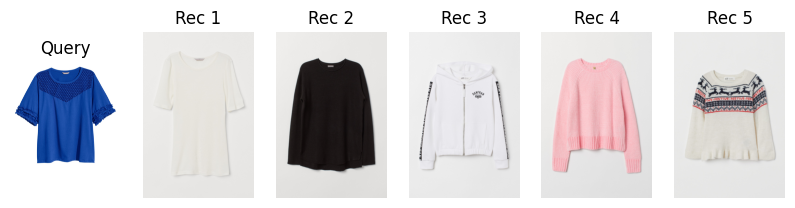

In [37]:
def visualize_knn_recommendations(query_image_path, recommended_paths, recommended_indices):
    '''
    Visualize the query image and its KNN-based recommendations.
    '''
    plt.figure(figsize=(10, 5))
    
    # Show the query image
    plt.subplot(1, len(recommended_indices) + 1, 1)
    img = Image.open(query_image_path)
    plt.imshow(img)
    plt.title('Query')
    plt.axis('off')

    
    # Show the top-k recommended images
    for i, idx in enumerate(recommended_indices):
        plt.subplot(1, len(recommended_indices) + 1, i + 2)
        img = Image.open(f'../{recommended_paths[i]}')
        plt.imshow(img)
        plt.title(f'Rec {i + 1}')
        plt.axis('off')
    
    plt.show()

# Example usage
visualize_knn_recommendations(query_image_path, recommended_paths, recommended_indices)


In [38]:
len(paths)

6000